This notebook contains plots produced in the validation sections of the paper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns 
sns.set_style('ticks')

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats

import pickle
import re
import os
import copy

from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data


from matplotlib.font_manager import FontProperties
fp2 = FontProperties(fname=r"../fonts/Font Awesome 5 Free-Solid-900.otf")

Set Theano Environmental Variables for Parallelisation


In [3]:
data = preprocess_data('../merged_data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [4]:
np.median(pickle.load(open("traces/complexdiffeffv3.pkl", "rb")).CM_Alpha, axis=0)

array([0.01222143, 0.16165295, 0.18137999, 0.09198622, 0.22941961,
       0.10690537, 0.10142794, 0.38761029, 0.15958854])

In [5]:
default_res = pickle.load(open("traces/complexdiffeffv3.pkl", "rb")).CMReduction

In [6]:
results_base_dir = "../server/sensitivity_complex/"

def tag_fname_to_label(tag, fname):    
    if tag == "cases_threshold":
        r = re.search(r"(cases_t)(\d*)", fname)
        return r.groups()[1]
    
    if tag == "deaths_threshold":
        r = re.search(r"(deaths_t)(\d*)", fname)
        return r.groups()[1]
    
    if tag == "any_npi_active":
        return "Bonus Any-Active NPI"
    
    if tag == "delay_schools":
        return "School & University\nClosure Delayed"
    
    if tag == "scalings":
        if "simple" in fname:
            return "Random Constant Scaling"
        else:
            return "Time-Varying Correction"
    
    if tag == "npi_leaveout":
        npi_names = data.CMs
        r = re.search(r"(\d*)", fname)[0]
        label = f"{npi_names[int(r[0])]}"
        for npi in r[1:]:
            label += f",\n{npi_names[int(npi)]}"
            
        return label
    
    if tag == "growth_noise":
        npi_names = data.CMs
        r = re.search(r"(growth_noise)-(\d*.\d*)", fname)
        
        return r.groups()[1]
            
    if tag == "NPI_prior":
        if "icl" in fname:
            return "Flaxman et. al."
        
        if "half_normal" in fname:
            return "$\\alpha_i \sim$Half Normal$(0.2^2)$"
        
        if "normal" in fname:
            return "$\\alpha_i \sim$Normal$(0, 0.2^2)$"
        
    if tag == "oxcgrt":
        npi_names = ['Travel Screen/Quarantine', 'Travel Bans', 'Public Transport Limited',
                          'Internal Movement Limited', 'Public Information Campaigns', 'Symptomatic Testing']
        r = re.search(r"(\d*)", fname)[0]
        label = f"{npi_names[int(r[0])]}"
        for npi in r[1:]:
            label += f",\n{npi_names[int(npi)]}"
        return label
            
    if tag == "R_prior":
        r = re.search(r"(R_prior-)(\d*.\d*)", fname)
        val = r.groups()[1]
        return val

    if tag == "region_holdout":
        return fname[:2]
    
    if tag == "structural":
        if "additive" in fname:
            return "Additive"
        if "different_effects" in fname:
            return "Different Effects"
        if "cases" in fname:
            return "Only Case Data"
        if "deaths" in fname:
            return "Only Death Data"
        if "noisy" in fname:
            return "Noisy-R"
        if "discrete_renewal_fixed_gi" in fname:
            return "Discrete Renewal$^*$"
        if "discrete_renewal" in fname:
            return  "Discrete Renewal (Unknown GI)"
        
    if tag == "epiparam_prior":
        gi = re.search(r"(gi_mean_mean-)(\d*.\d*)", fname)[1]
        cd = re.search(r"(gi_mean_mean-)(\d*.\d*)", fname)[1]
        dd = re.search(r"(gi_mean_mean-)(\d*.\d*)", fname)[1]
        
        
    return f"{tag} - {fname}"

def load_tagged_traces(result_base_dir, tag):
    path = os.path.join(results_base_dir, tag)
    
    all_traces = []
    for filedir, _, files in os.walk(path):
        for f in files:
            if '.txt' in f and 'CasesDelay' not in f and 'DeathsDeath' not in f and '_GI_' not in f:
                try:
                    trace = np.loadtxt(os.path.join(filedir, f))
                    all_traces.append([trace, tag_fname_to_label(tag, f)])
                except Exception as e:
                    print(e)
                    
    return all_traces

def search_tagged_traces(result_base_dir, tag, search_key):
    path = os.path.join(results_base_dir, tag)
    
    for filedir, _, files in os.walk(path):
        for f in files:
            if '.txt' in f and search_key in f:
                    trace = np.loadtxt(os.path.join(filedir, f))
                    label =  tag_fname_to_label(tag, f)
                    return (trace, label)
    
    print('No experiment found')
    return None

In [7]:
colors = [*sns.color_palette("colorblind"), *sns.color_palette("dark")]

derived_features_comb = [ #()"Healthcare Infection Control", [0]),
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to 1000\npeople or less", [1]),
 ("Gatherings limited to 100\npeople or less", [1, 2]),
 ("Gatherings limited to 10\npeople or less", [1, 2, 3]),
 ("Some businesses closed", [4]),
 ("Most businesses closed", [4, 5]),
 ("Schools and universities\nclosed", [6, 7]),
 ("Stay-at-home order\n(with exemptions)", [8]),
 ]


derived_features_uncomb = [ #()"Healthcare Infection Control", [0]),
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to 1000\npeople or less", [1]),
 ("Gatherings limited to 100\npeople or less", [2]),
 ("Gatherings limited to 10\npeople or less", [3]),
 ("Some businesses closed", [4]),
 ("Most businesses closed", [5]),
 ("Schools and universities\nclosed", [6, 7]),
 ("Stay-at-home order\n(with exemptions)", [8]),
 ]

derived_features = derived_features_comb

cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)
cm_plot_style = [
            ("\uf963", "black"), # mask
            ("\uf0c0", cols[0]), # ppl
            ("\uf0c0", cols[1]), # ppl
            ("\uf0c0", cols[2]), # ppl
            ("\uf07a", cols[0]), # shop 1
            ("\uf07a", cols[2]), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq

def add_trace_to_plot(res, y_off, col, label, alpha, width, size=8, zeros=None):
    nS, _ = res.shape
    nF = len(derived_features)
    derived_samples = np.zeros((nS, nF))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.ones(nS)
        for r in prodrows:
            samples = samples * res[:, r] 
        derived_samples[:, f_i] = samples

    res = derived_samples
    res = 100*(1-res)
    
    if zeros is not None:
        for z in zeros:
            if z < nF:
                res[:, z] = 1e5
    
    y_vals = -1 * np.arange(nF)
    plt.plot([100], [100], color=col, linewidth=1, alpha=alpha, label=label)
    mn, med, li, ui, lq, uq = produce_ranges(res)
    plt.scatter(med, y_vals+y_off, marker="|", color=col, s=size, alpha=alpha)
    for cm in range(nF):
        plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=width)
        plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=width)
        
def add_additive_trace_to_plot(res, y_off, col, label, alpha, width, size=8, zeros=None):
    nS, _ = res.shape
    nF = len(derived_features)
    derived_samples = np.zeros((nS, nF))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.zeros(nS)
        for r in prodrows:
            samples = samples + res[:, r] 
        derived_samples[:, f_i] = samples

    res = derived_samples
    res = 100*res
    
    if zeros is not None:
        for z in zeros:
            if z < nF:
                res[:, z] = 1e5
                
    print(np.median(derived_samples, axis=0))
    
    y_vals = -1 * np.arange(nF)
    plt.plot([100], [100], color=col, linewidth=1, alpha=alpha, label=label)
    mn, med, li, ui, lq, uq = produce_ranges(res)
    plt.scatter(med, y_vals+y_off, marker="|", color=col, s=size, alpha=alpha)
    for cm in range(nF):
        if cm > 7:
            plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25*0.25, linewidth=width, linestyle="--")
            plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75*0.25, linewidth=width, linestyle="--")
        else:
            plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=width)
            plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=width)
        
        
        
def setup_large_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    ax = plt.gca()
    x_min = -25
    x_max = 75
    plt.plot([0, 0], [1, -(nF+2)], "--k", linewidth=0.5)
    
#     plt.plot([17.5, 17.5], [1, -(nF+2)], "--", linewidth=0.5, color=cols[0])
#     plt.plot([35, 35], [1, -(nF+2)], "--", linewidth=0.5, color=cols[0])
    
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=125)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 8*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average reduction in $R_t$,\nin the context of our data", fontsize=8)
        
def setup_larger_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    ax = plt.gca()
    x_min = -25
    x_max = 75
    plt.plot([0, 0], [1, -(nF+2)], "--k", linewidth=0.5)
#     plt.plot([17.5, 17.5], [1, -(nF+2)], "--", linewidth=0.5, color=cols[0])
#     plt.plot([35, 35], [1, -(nF+2)], "--", linewidth=0.5, color=cols[0])
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=125)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 9*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=12, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average reduction in $R_t$\n, in the context of our data", fontsize=8)
    
def setup_small_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    ax = plt.gca()
    x_min = -25
    x_max = 75
    plt.plot([0, 0], [1, -(nF+2)], "--k", linewidth=0.5)
#     plt.plot([17.5, 17.5], [1, -(nF+2)], "--", linewidth=0.5, color=cols[0])
#     plt.plot([35, 35], [1, -(nF+2)], "--", linewidth=0.5, color=cols[0])
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [0, 50, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=125)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 13*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average reduction in $R_t$, in the context of our data", fontsize=8)
        
class ResultsObject():
    def __init__(self, indx, trace):
        self.CMReduction = trace.CMReduction
        self.RegionR = trace.RegionR[:, indx]
        self.InfectedCases = trace.InfectedCases[:, indx, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indx, :]
        self.ExpectedCases = trace.ExpectedCases[:, indx, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indx, :]

In [8]:
def combine_trace(trace, derived_features):
    nS, _ = trace.shape
    nCMs = len(derived_features)
    derived_samples = np.zeros((nS, nCMs))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.ones(nS)
        for r in prodrows:
            samples = samples * trace[:, r] 
        derived_samples[:, f_i] = samples

    res = copy.deepcopy(derived_samples)
    res = 100*(1-res)
    
    return res

In [9]:
def produce_score(default_res, traces, exclude=None):
    default_med = 1 - np.median(default_res, axis=0)
    
    regression_table = np.zeros((0, 2))
    labels_used = []
    
    for trace, label in traces:
        if exclude is not None:
            if isinstance(exclude, list):
                flags = [e in label for e in exclude]
                if any(flags):
                    continue
            else:
                if exclude in label:
                    continue
        
        med = 1 - np.median(trace[:, :9], axis=0)
        med = 1 - med if 'Additive' in label else med
        
        regression_table = np.append(regression_table, np.vstack([default_med, med]).T, axis=0)
        labels_used.append(label)
    
    mask = ~ np.any(np.isnan(regression_table), axis=-1)
    _, _, score, _, _ = stats.linregress(regression_table[mask])
    
    print(f'Produced stored using {[labels_used]}')
    return score

In [10]:
def produce_score_sd(default_res, traces, derived_features, exclude=None):
    default_med = np.median(combine_trace(default_res, derived_features), axis=0)
    
    median_values = np.zeros((0, len(default_med)))
    median_values = np.append(median_values, default_med.reshape((1, len(derived_features))), axis=0)
    labels_used = []
    
    
    for trace, label in traces:
        if exclude is not None:
            if isinstance(exclude, list):
                flags = [e in label for e in exclude]
                if any(flags):
                    continue
            else:
                if exclude in label:
                    continue
        
        med = np.median(combine_trace(trace[:, :9], derived_features), axis=0)
        median_values = np.append(median_values, med.reshape((1, len(derived_features))), axis=0)
        
    med_stds = np.nanstd(median_values, axis=0)
    print(med_stds)
    score = np.mean(med_stds)
    print(score)
    
    print(f'Produced stored using {[labels_used]}')
    return score

# Category 1: Structural Sensitivity

[0. 0. 0. 0. 0. 0. 0. 0.]
0.0
Produced stored using [[]]
No experiment found


TypeError: cannot unpack non-iterable NoneType object

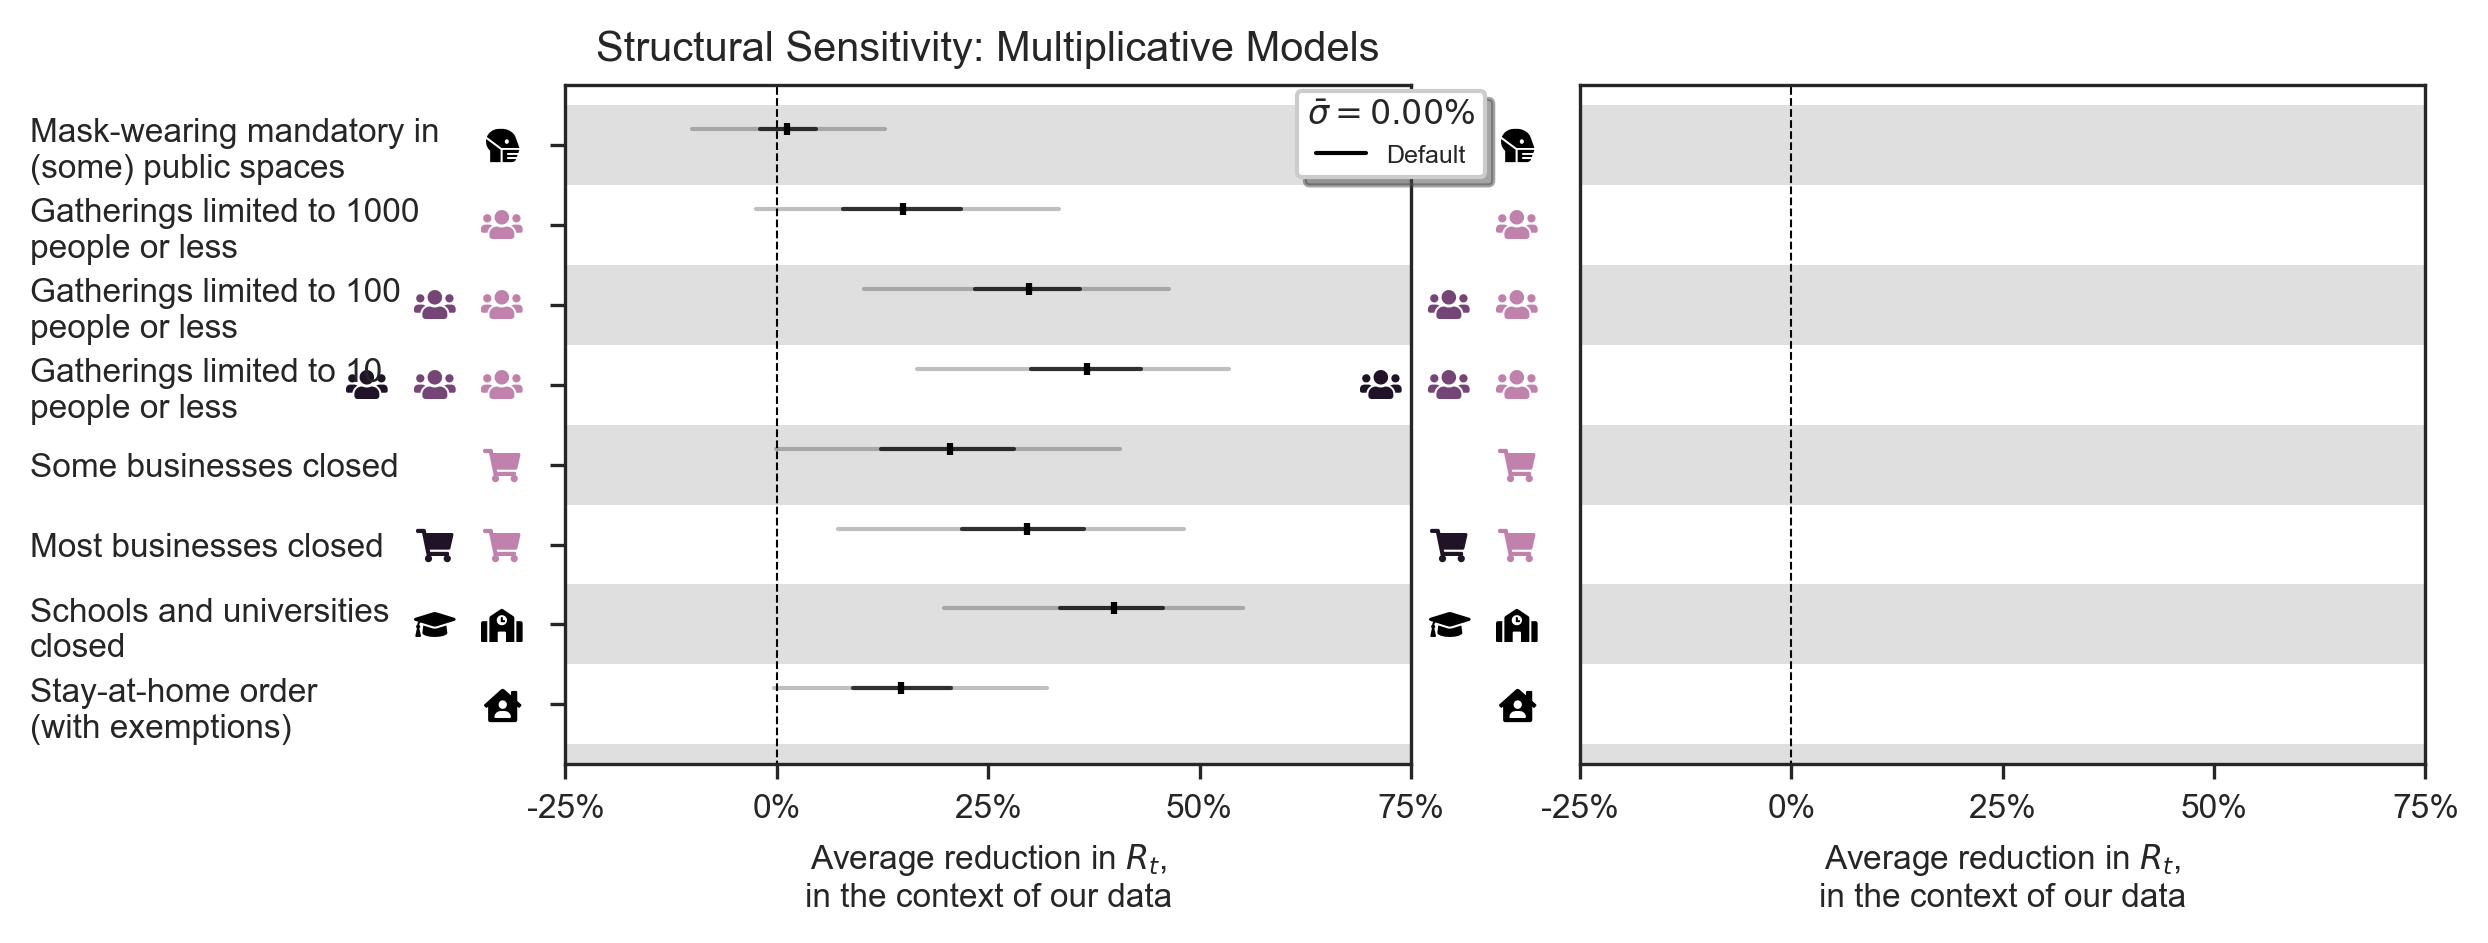

In [11]:
traces = load_tagged_traces(results_base_dir, 'structural')
score = produce_score_sd(default_res, traces, derived_features_comb, ['Only', 'Unknown', 'Additive'])
traces = [(trace, label) for trace, label in traces if ('Only' not in label and 'Additive' not in label and 'Unknown' not in label)]

fig = plt.figure(figsize=(8, 3), dpi=300)
plt.subplot(121)
setup_large_plot()
y_off = -np.linspace(-0.2, 0.2, len(traces)+1)
width = 1
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace, y_off[i], colors[i], label, 1, width) 
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 
plt.xlabel("Average reduction in $R_t$,\nin the context of our data", fontsize=8)

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.85, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("Structural Sensitivity: Multiplicative Models", fontsize=10)

plt.subplot(122)
setup_large_plot(False, True, True)
trace, label = search_tagged_traces(results_base_dir, 'structural', 'additive')
add_additive_trace_to_plot(trace, 0, colors[0], label, 1, width)
plt.title("Structural Sensitivity: Additive Model", fontsize=10)
plt.xlabel("Average reduction in $R_t$,\nas a percentage of $R_0$,\nin the context of our data", fontsize=8)

plt.tight_layout()
plt.savefig(f"figs/validation/FigureSSA.pdf", bbox_inches='tight')

In [12]:
np.sum(trace, axis=1)

NameError: name 'trace' is not defined

# Category 2: Unobserved Effects

[0.1471816  1.44917245 2.99423703 3.39341465 0.08750713 0.70886454
 1.77146044 1.31382321]
1.4832076325457046
Produced stored using [[]]
[0.1471816  1.44917245 2.99423703 3.39341465 0.08750713 0.70886454
 1.77146044 1.31382321]
1.4832076325457046
Produced stored using [[]]
[0.2102166  2.77914241 2.40587537 2.35256212 1.44535179 1.94146132
 2.38114429 1.78433692]
1.9125113532267877
Produced stored using [[]]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


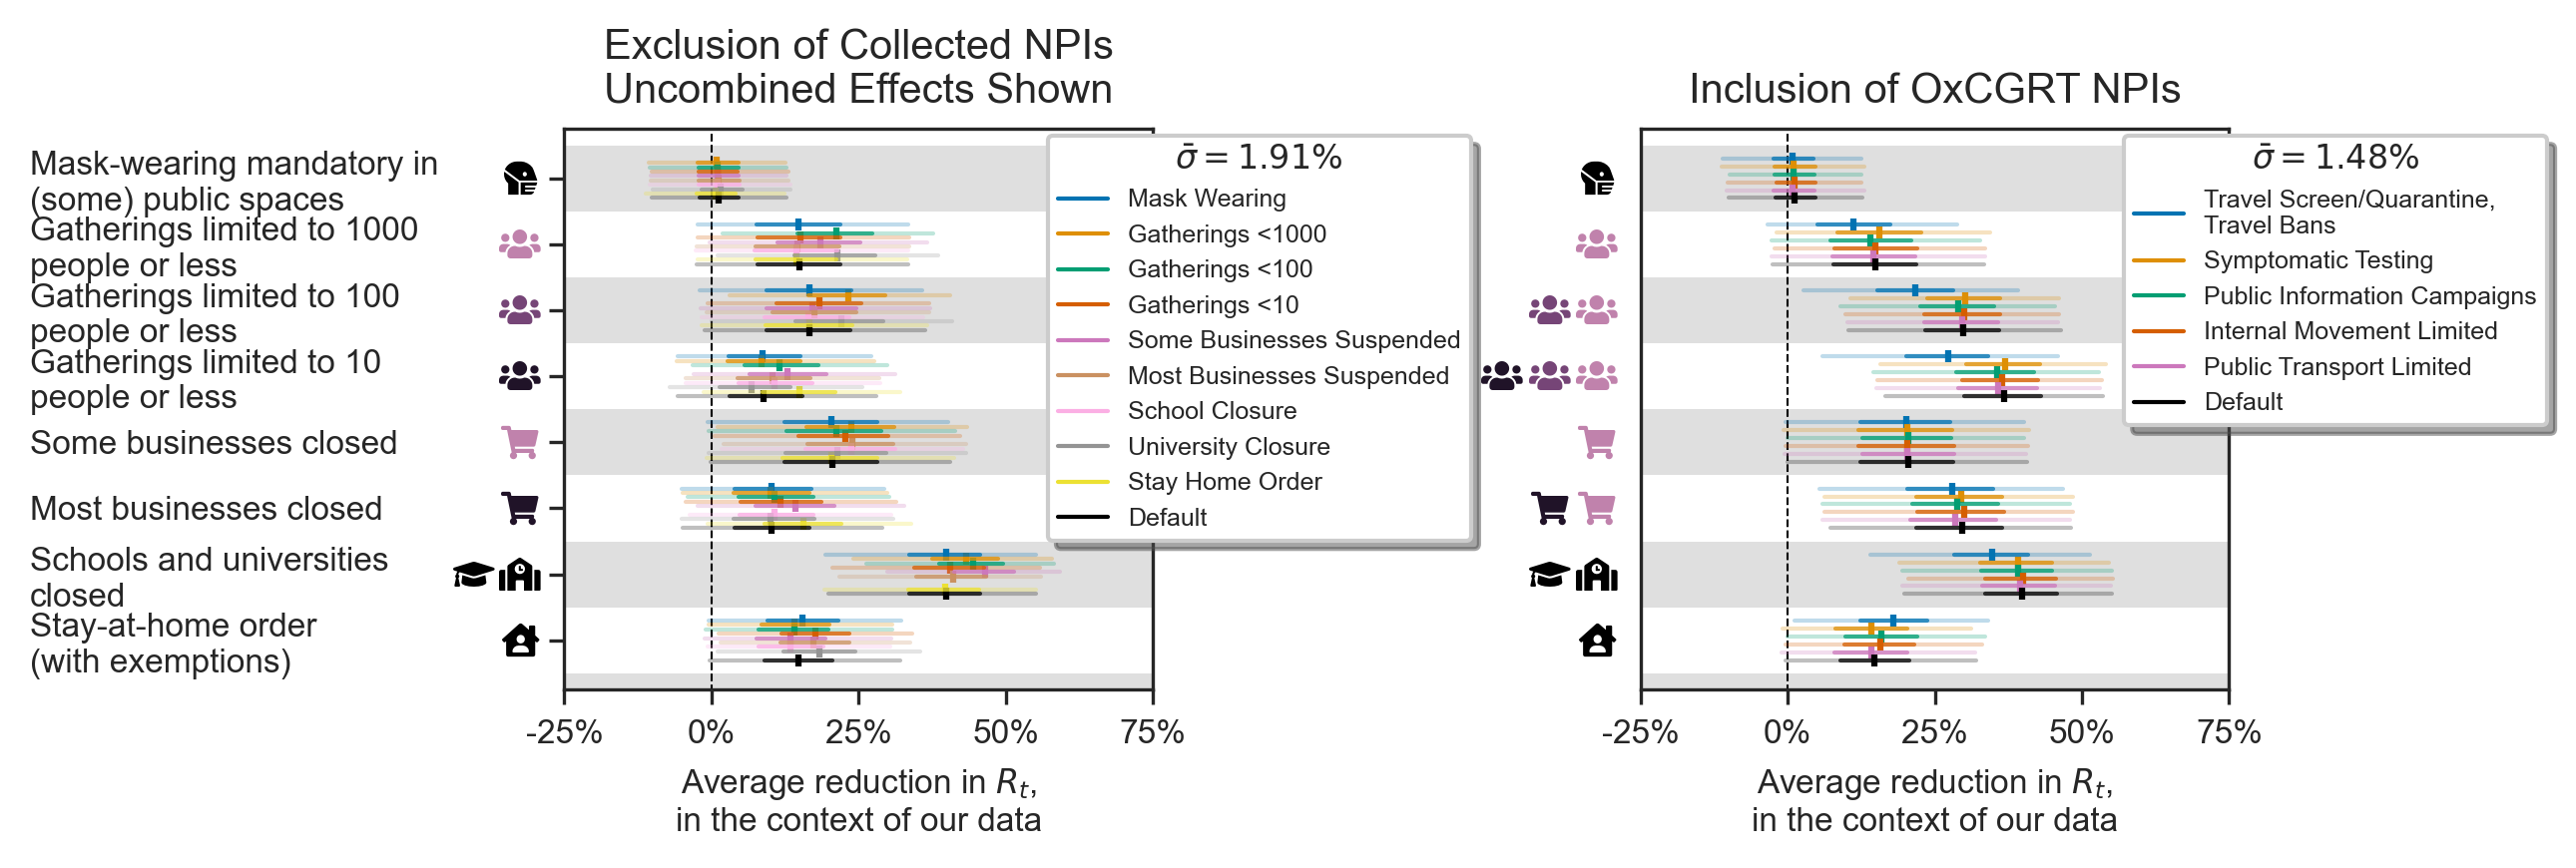

In [13]:
fig = plt.figure(figsize=(8.5, 3), dpi=300)

plt.subplot(122)
setup_large_plot(False, True, True)

traces = load_tagged_traces(results_base_dir, "oxcgrt")
testing_index = [n for _, n in traces].index('Symptomatic Testing')
orig = copy.deepcopy(traces[testing_index][0])
traces[testing_index][0] = orig[:, [0, 2, 3, 4, 5, 6, 7, 8, 9]]
        
# score = produce_score(default_res, traces)
score = produce_score_sd(default_res, traces, derived_features_comb)

y_off = -np.linspace(-0.3, 0.3, len(traces)+1)
width = 1
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 

score = produce_score_sd(default_res, traces, derived_features_comb)
plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.8, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("Inclusion of OxCGRT NPIs", fontsize="10")

plt.subplot(121)
derived_features = derived_features_uncomb
setup_large_plot(True, True, True)
traces = load_tagged_traces(results_base_dir, "npi_leaveout")

# remove values which are invalid!
labels = [l for _, l in traces]
for l_i, label in enumerate(labels):
    for cm_i, cm in enumerate(data.CMs):
        if '<' not in cm and cm in label:
            traces[l_i][0][:, cm_i] = np.nan
        if cm == label:
            traces[l_i][0][:, cm_i] = np.nan
        
score = produce_score_sd(default_res, traces, derived_features_uncomb)

order = [*data.CMs]
t_is = [labels.index(o) for o in order]

y_off = -np.linspace(-0.3, 0.3, len(traces)+1)
width = 1
for i, t_i in enumerate(t_is):
    trace, label = traces[t_i]
    add_trace_to_plot(trace, y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 
    
derived_features = derived_features_comb

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.8, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("Exclusion of Collected NPIs\nUncombined Effects Shown", fontsize="10")
plt.tight_layout(w_pad=0)
plt.savefig(f"figs/validation/FigureUOB.pdf", bbox_inches='tight')

In [ ]:
labels

# data sensitivity

#### Data Type

No experiment found
No experiment found


TypeError: cannot unpack non-iterable NoneType object

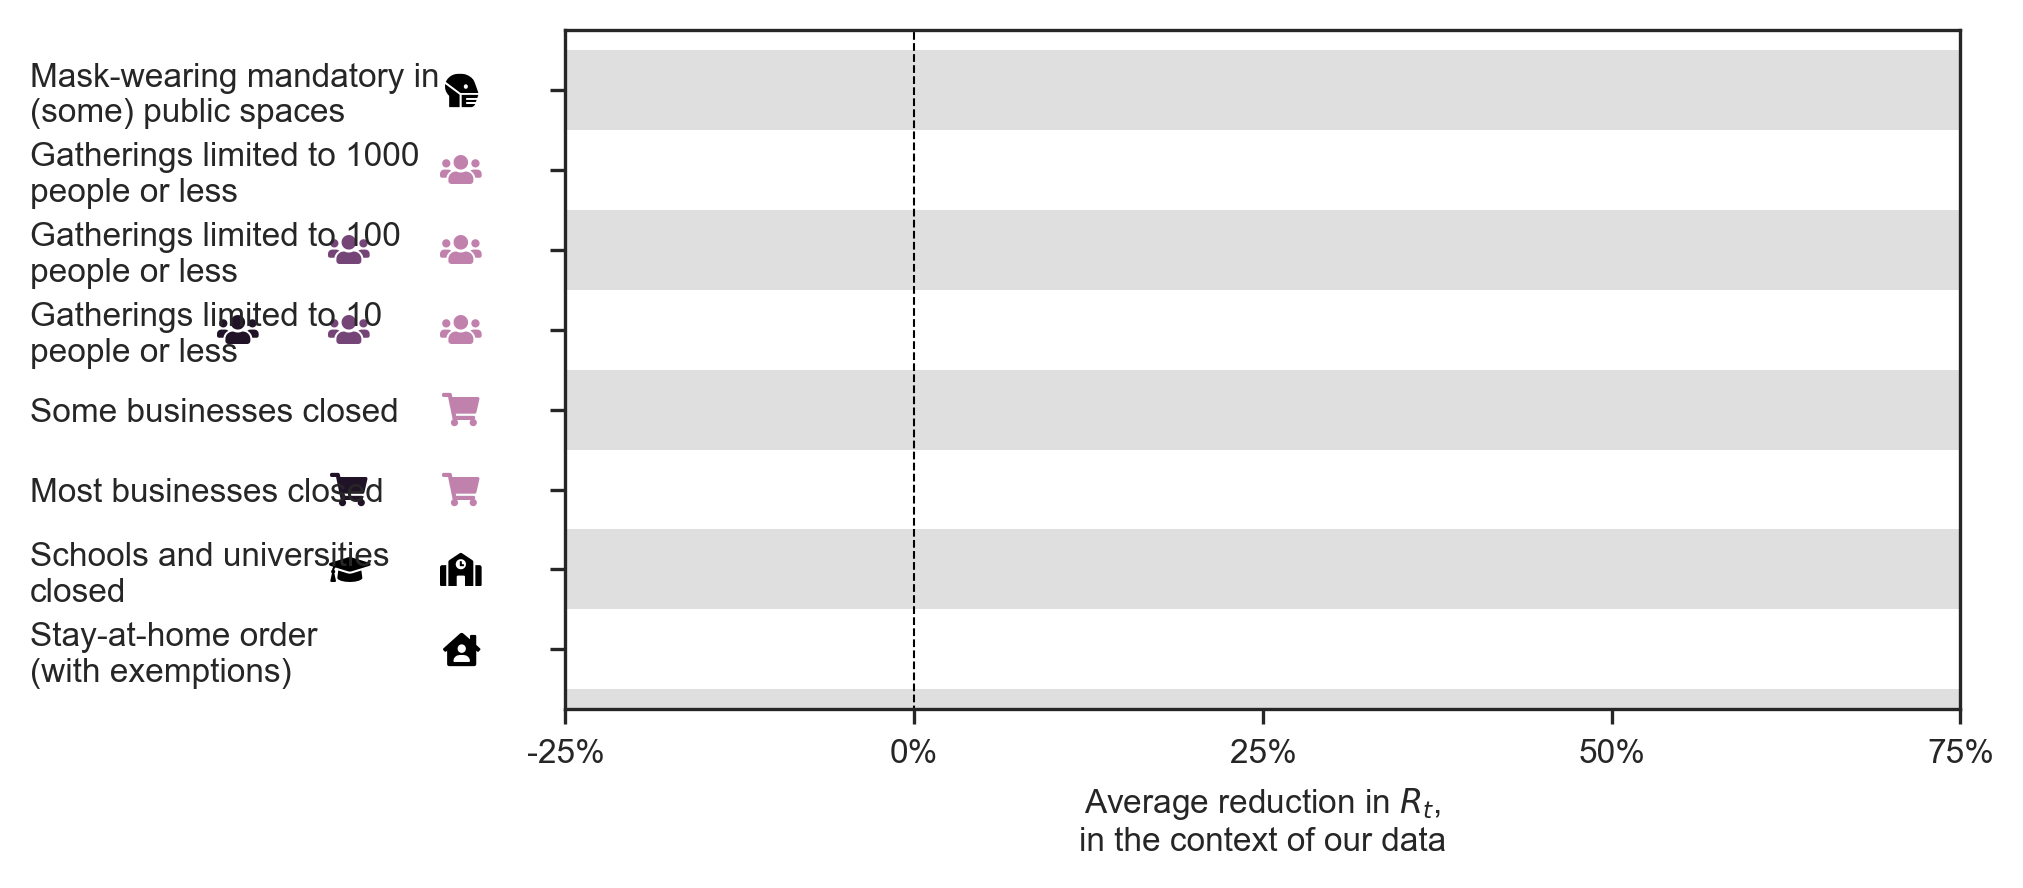

In [14]:
fig = plt.figure(figsize=(6, 3), dpi=300)
setup_large_plot()
traces = [search_tagged_traces(results_base_dir, 'structural', 'cases'), search_tagged_traces(results_base_dir, 'structural', 'deaths')]
score = produce_score(default_res, traces)
y_off = -np.linspace(-0.2, 0.2, len(traces)+1)
colors_h = [colors[0], colors[3]]
width = 2
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace, y_off[i], colors_h[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width)  

score = produce_score_sd(default_res, traces, derived_features_comb)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.35, 1.01), fontsize=8, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=10)
plt.title("Data Type", fontsize=10)

plt.tight_layout()
plt.savefig(f"figs/validation/FigureDataType.pdf", bbox_inches='tight')

#### Country Sensitivity

No handles with labels found to put in legend.


[0.33777945 1.77151829 1.2121633  1.01945182 2.81891872 2.23289849
 1.39278829 1.2712589 ]
1.507097157555895
Produced stored using [[]]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


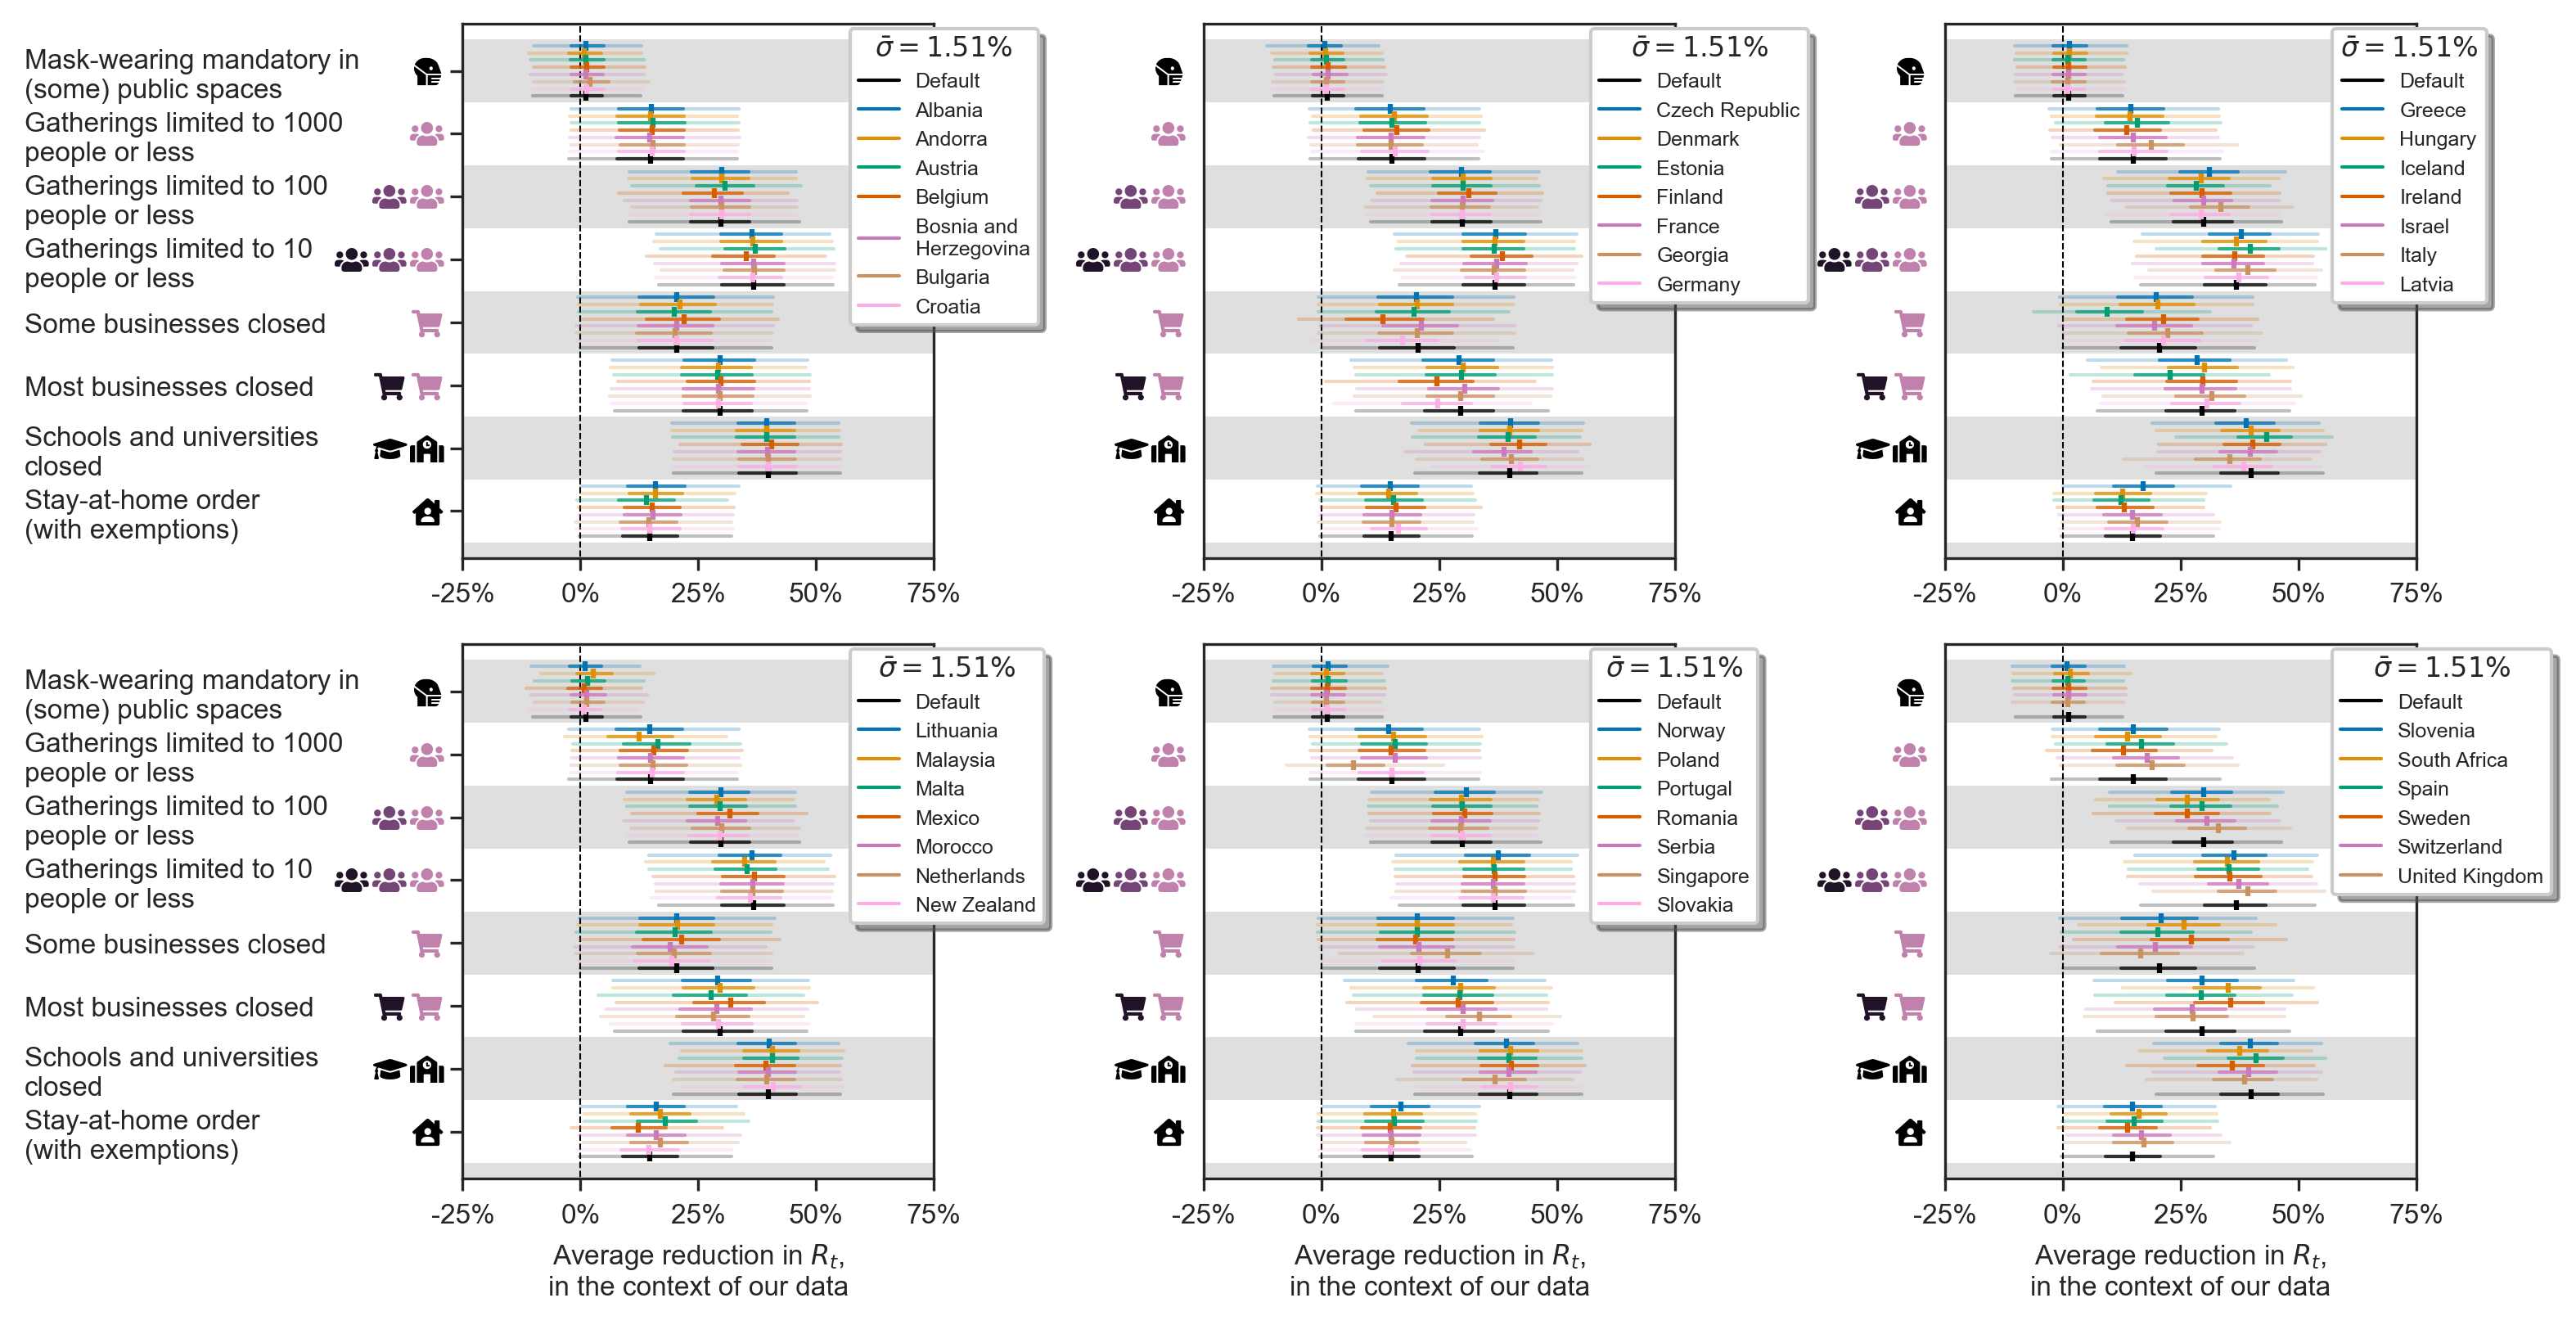

In [15]:
fig = plt.figure(figsize=(10.5, 5.5), dpi=300)

traces = load_tagged_traces(results_base_dir, 'region_holdout')
score = produce_score_sd(default_res, traces, derived_features_comb)

y_off = -np.linspace(-0.4, 0.4, 8)
for r_i, r in enumerate(data.Rs):
    r_i_p = r_i % 7 
    if r_i_p == 0:
        plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.8, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
        plt.subplot(2, 3, int(r_i/7) + 1)
        
        xlabel = False if (int(r_i/7) + 1) < 4 else True
        
        if (int(r_i/7) + 1) == 1 or (int(r_i/7) + 1) == 4:
            setup_large_plot(xlabel=xlabel)
        else:
            setup_large_plot(False, xlabel=xlabel)
        add_trace_to_plot(default_res, y_off[-1], "k", "Default", 1, 1)
    trace, _ = search_tagged_traces(results_base_dir, 'region_holdout', r)
    label = data.RNames[r][0]
    if 'and' in label and 'Bosnia' in label:
        label = 'Bosnia and\nHerzegovina'
    add_trace_to_plot(trace, y_off[r_i_p], colors[r_i_p], label, 1, 1)
    
#     plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(0.8, 1.01), fontsize=8, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=10)
plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.8, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.tight_layout(w_pad=0.15)
plt.savefig(f"figs/validation/FigureCountryLeaveout.pdf", bbox_inches='tight')

In [16]:
f;

NameError: name 'f' is not defined

#### Thresholds

In [ ]:
fig = plt.figure(figsize=(8, 3), dpi=300)

plt.subplot(121)
setup_large_plot()

traces = load_tagged_traces(results_base_dir, "cases_threshold")
traces = [(trace, label) for trace, label in traces if '10' not in label]
score = produce_score_sd(default_res, traces, derived_features_comb)

y_off = -np.linspace(-0.25, 0.25, len(traces)+1)
width = 1
traces.sort(key= lambda x: int(x[1]))
for i, (trace, label) in enumerate(traces):
    if i<2:
        add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
        
    if i == 2:
        add_trace_to_plot(default_res, y_off[i], 'k', "Default (100)", 1, width)
    
    if i > 1:
        add_trace_to_plot(trace[:, :9], y_off[i+1], colors[i], label, 1, width)

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("Minimum Cases Threshold", fontsize="10")

plt.subplot(122)
setup_large_plot(False, True, True)
traces = load_tagged_traces(results_base_dir, "deaths_threshold")
score = produce_score_sd(default_res, traces, derived_features_comb)

traces.sort(key= lambda x: int(x[1]))

y_off = -np.linspace(-0.25, 0.25, len(traces)+1)
width = 1
for i, (trace, label) in enumerate(traces):
    if i<2:
        add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
        
    if i == 2:
        add_trace_to_plot(default_res, y_off[i], 'k', "Default (10)", 1, width)
    
    if i > 1:
        add_trace_to_plot(trace[:, :9], y_off[i+1], colors[i], label, 1, width)
 
plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("Minimum Deaths Threshold", fontsize="10")
plt.tight_layout()
plt.savefig(f"figs/validation/FigureThresholds.pdf", bbox_inches='tight')

In [ ]:
f;

# additional epi

In [ ]:
fig = plt.figure(figsize=(8, 3), dpi=300)

plt.subplot(121)
setup_large_plot()

traces = load_tagged_traces(results_base_dir, "R_prior")
score = produce_score_sd(default_res, traces, derived_features_comb)

y_off = -np.linspace(-0.25, 0.25, len(traces)+1)
width = 1
traces.sort(key= lambda x: float(x[1]))
for i, (trace, label) in enumerate(traces):
    if i<2:
        add_trace_to_plot(trace[:, :9], y_off[i], colors[i], f'$\\mu[R] ={label}$', 1, width)
        
    if i == 2:
        add_trace_to_plot(default_res, y_off[i], 'k', f'Default\n$\\mu[R] =3.28$', 1, width)
    
    if i > 1:
        add_trace_to_plot(trace[:, :9], y_off[i+1], colors[i], f'$\\mu[R] ={label}$', 1, width)

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("$R_0$ prior", fontsize=10)

plt.subplot(122)
setup_large_plot(False, True, True)
traces = load_tagged_traces(results_base_dir, "NPI_prior")
score = produce_score_sd(default_res, traces, derived_features_comb)

# traces.sort(key= lambda x: int(x[1]))

y_off = -np.linspace(-0.25, 0.25, len(traces)+1)
width = 1
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 
    
plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("NPI Effectiveness Prior", fontsize=10)
plt.tight_layout()
plt.savefig(f"figs/validation/FigureAdditionalEpi.pdf", bbox_inches='tight')

# Iceland, Sweden Plot

In [ ]:
plt.figure(figsize=(4,3), dpi=300)

derived_features = [
 ("Schools closed", [6]),
 ("Universities closed", [7]),
 ("Schools and univerisities closed", [6, 7]),
 ]

nF = len(derived_features)

ax = plt.gca()
x_min = -25
x_max = 100
plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nF+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]

plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
yax = ax.get_yaxis()
yax.set_tick_params(pad=150)

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nF - 0.25), 0.75])

for cm in range(len(derived_features)):
    for i, val in enumerate(derived_features[cm][1]):
        plt.text(x_min - 7.5 - 8*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                     fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 

plt.xlabel("Average reduction in $R_t$,\nin the context of our data", fontsize=8)


iceland = search_tagged_traces(results_base_dir, 'region_holdout', 'IS')[0]
sweden = search_tagged_traces(results_base_dir, 'region_holdout', 'SE')[0]
y_off = -np.linspace(-0.2, 0.2, 3)
add_trace_to_plot(iceland, y_off[0], colors[0], "Iceland Excluded", 1, 2)
add_trace_to_plot(sweden, y_off[1], colors[1], "Sweden Excluded", 1, 2)
add_trace_to_plot(default_res, y_off[-1], "k", "Default", 1, 2)
plt.legend(shadow=True, fancybox=True, fontsize=6)
plt.title("Schools and Universities Sensitivity", fontsize=10)
plt.savefig(f"figs/validation/FigureISSE.pdf", bbox_inches='tight')

In [ ]:
f;

# Global Sensitivity

In [19]:
derived_features = derived_features_comb

In [20]:
def fname_to_params(fname):
    gi = float(re.search(r"(gi_mean_mean)-(\d*.\d*)", fname).groups()[1])
    cd = float(re.search(r"(cases_mean_mean)-(\d*.\d*)", fname).groups()[1])
    dd = float(re.search(r"(deaths_mean_mean)-(\d*.\d*)", fname).groups()[1])
    
    return gi, cd, dd

def load_tagged_traces_gs(result_base_dir, tag):
    path = os.path.join(results_base_dir, tag)
    
    all_traces = []
    for filedir, _, files in os.walk(path):
        for f in files:
            if '.txt' in f:
                try:
                    trace = np.loadtxt(os.path.join(filedir, f))
                    
                    nS, _ = trace.shape
                    nF = len(derived_features)
                    derived_samples = np.zeros((nS, nF))

                    for f_i, (_, prodrows) in enumerate(derived_features):
                        samples = np.ones(nS)
                        for r in prodrows:
                            samples = samples * trace[:, r] 
                        derived_samples[:, f_i] = samples

                    res = derived_samples
                    median = np.median(res, axis=0)
                    
                    gi, cd, dd = fname_to_params(f)
                    
                    all_traces.append([median, gi, cd, dd, trace])
                    print(f'{len(all_traces)} Exps')
                except Exception as e:
                    print(e)
                    
    return all_traces

In [21]:
global_traces = load_tagged_traces_gs(results_base_dir, 'epiparam_prior_all')

1 Exps
2 Exps
3 Exps
4 Exps
5 Exps
6 Exps
7 Exps
8 Exps
9 Exps
10 Exps
11 Exps
12 Exps
13 Exps
14 Exps
15 Exps
16 Exps
17 Exps
18 Exps
19 Exps
20 Exps
21 Exps
22 Exps
23 Exps
24 Exps
25 Exps
26 Exps
27 Exps
28 Exps
29 Exps
30 Exps
31 Exps
32 Exps
33 Exps
34 Exps
35 Exps
36 Exps
37 Exps
38 Exps
39 Exps
40 Exps
41 Exps
42 Exps
43 Exps
44 Exps
45 Exps
46 Exps
47 Exps
48 Exps
49 Exps
50 Exps
51 Exps
52 Exps
53 Exps
54 Exps
55 Exps
56 Exps
57 Exps
58 Exps
59 Exps
60 Exps
61 Exps
62 Exps
63 Exps
64 Exps
65 Exps
66 Exps
67 Exps
68 Exps
69 Exps
70 Exps
71 Exps
72 Exps
73 Exps
74 Exps
75 Exps
76 Exps
77 Exps
78 Exps
79 Exps
80 Exps
81 Exps
82 Exps
83 Exps
84 Exps
85 Exps
86 Exps
87 Exps
88 Exps
89 Exps
90 Exps
91 Exps
92 Exps
93 Exps
94 Exps
95 Exps
96 Exps
97 Exps
98 Exps
99 Exps
100 Exps
101 Exps
102 Exps
103 Exps
104 Exps
105 Exps
106 Exps
107 Exps
108 Exps
109 Exps
110 Exps
111 Exps
112 Exps
113 Exps
114 Exps
115 Exps
116 Exps
117 Exps
118 Exps
119 Exps
120 Exps
121 Exps
122 Exps
123 Exps
1

In [22]:
medians, gis, cds, dds, full_traces = list(zip(*global_traces))

In [23]:
produce_score_sd(default_res, [(t, '') for t in full_traces], derived_features_comb)

[1.17563517 5.3068647  3.3606825  1.44340412 2.41179583 3.2643541
 1.74262089 0.96732956]
2.4590858587849924
Produced stored using [[]]


2.4590858587849924

In [24]:
nS, _ = default_res.shape
nF = len(derived_features)
derived_samples = np.zeros((nS, nF))

for f_i, (_, prodrows) in enumerate(derived_features):
    samples = np.ones(nS)
    for r in prodrows:
        samples = samples * default_res[:, r] 
    derived_samples[:, f_i] = samples
    
default_median = np.median(derived_samples, axis=0)

In [25]:
unique_gis = np.unique(gis)
unique_cds = np.unique(cds)
unique_dds = np.unique(dds)

In [26]:
def gi_to_grid(cm, global_traces, unique_cds, unique_dds, gi, default_median):
    filtered_traces = list(filter(lambda t: t[1] == gi, global_traces))
    
    grid = np.zeros((len(unique_cds), len(unique_dds)))
    grid[:] = np.nan
    
    for meds, _, cd, dd, _ in filtered_traces:
        cd_ind = np.where(unique_cds == cd)
        dd_ind = np.where(unique_dds == dd)
        val = 100*(-meds[cm] + default_median[cm]) 
        grid[cd_ind, dd_ind] = val
    
    return grid

In [27]:
short_names = ['Mask Wearing', 'Gatherings <1000', 'Gatherings <100', 'Gatherings <10', 'Some Buss', 'Most Buss', 'Educat', 'Stay Home']

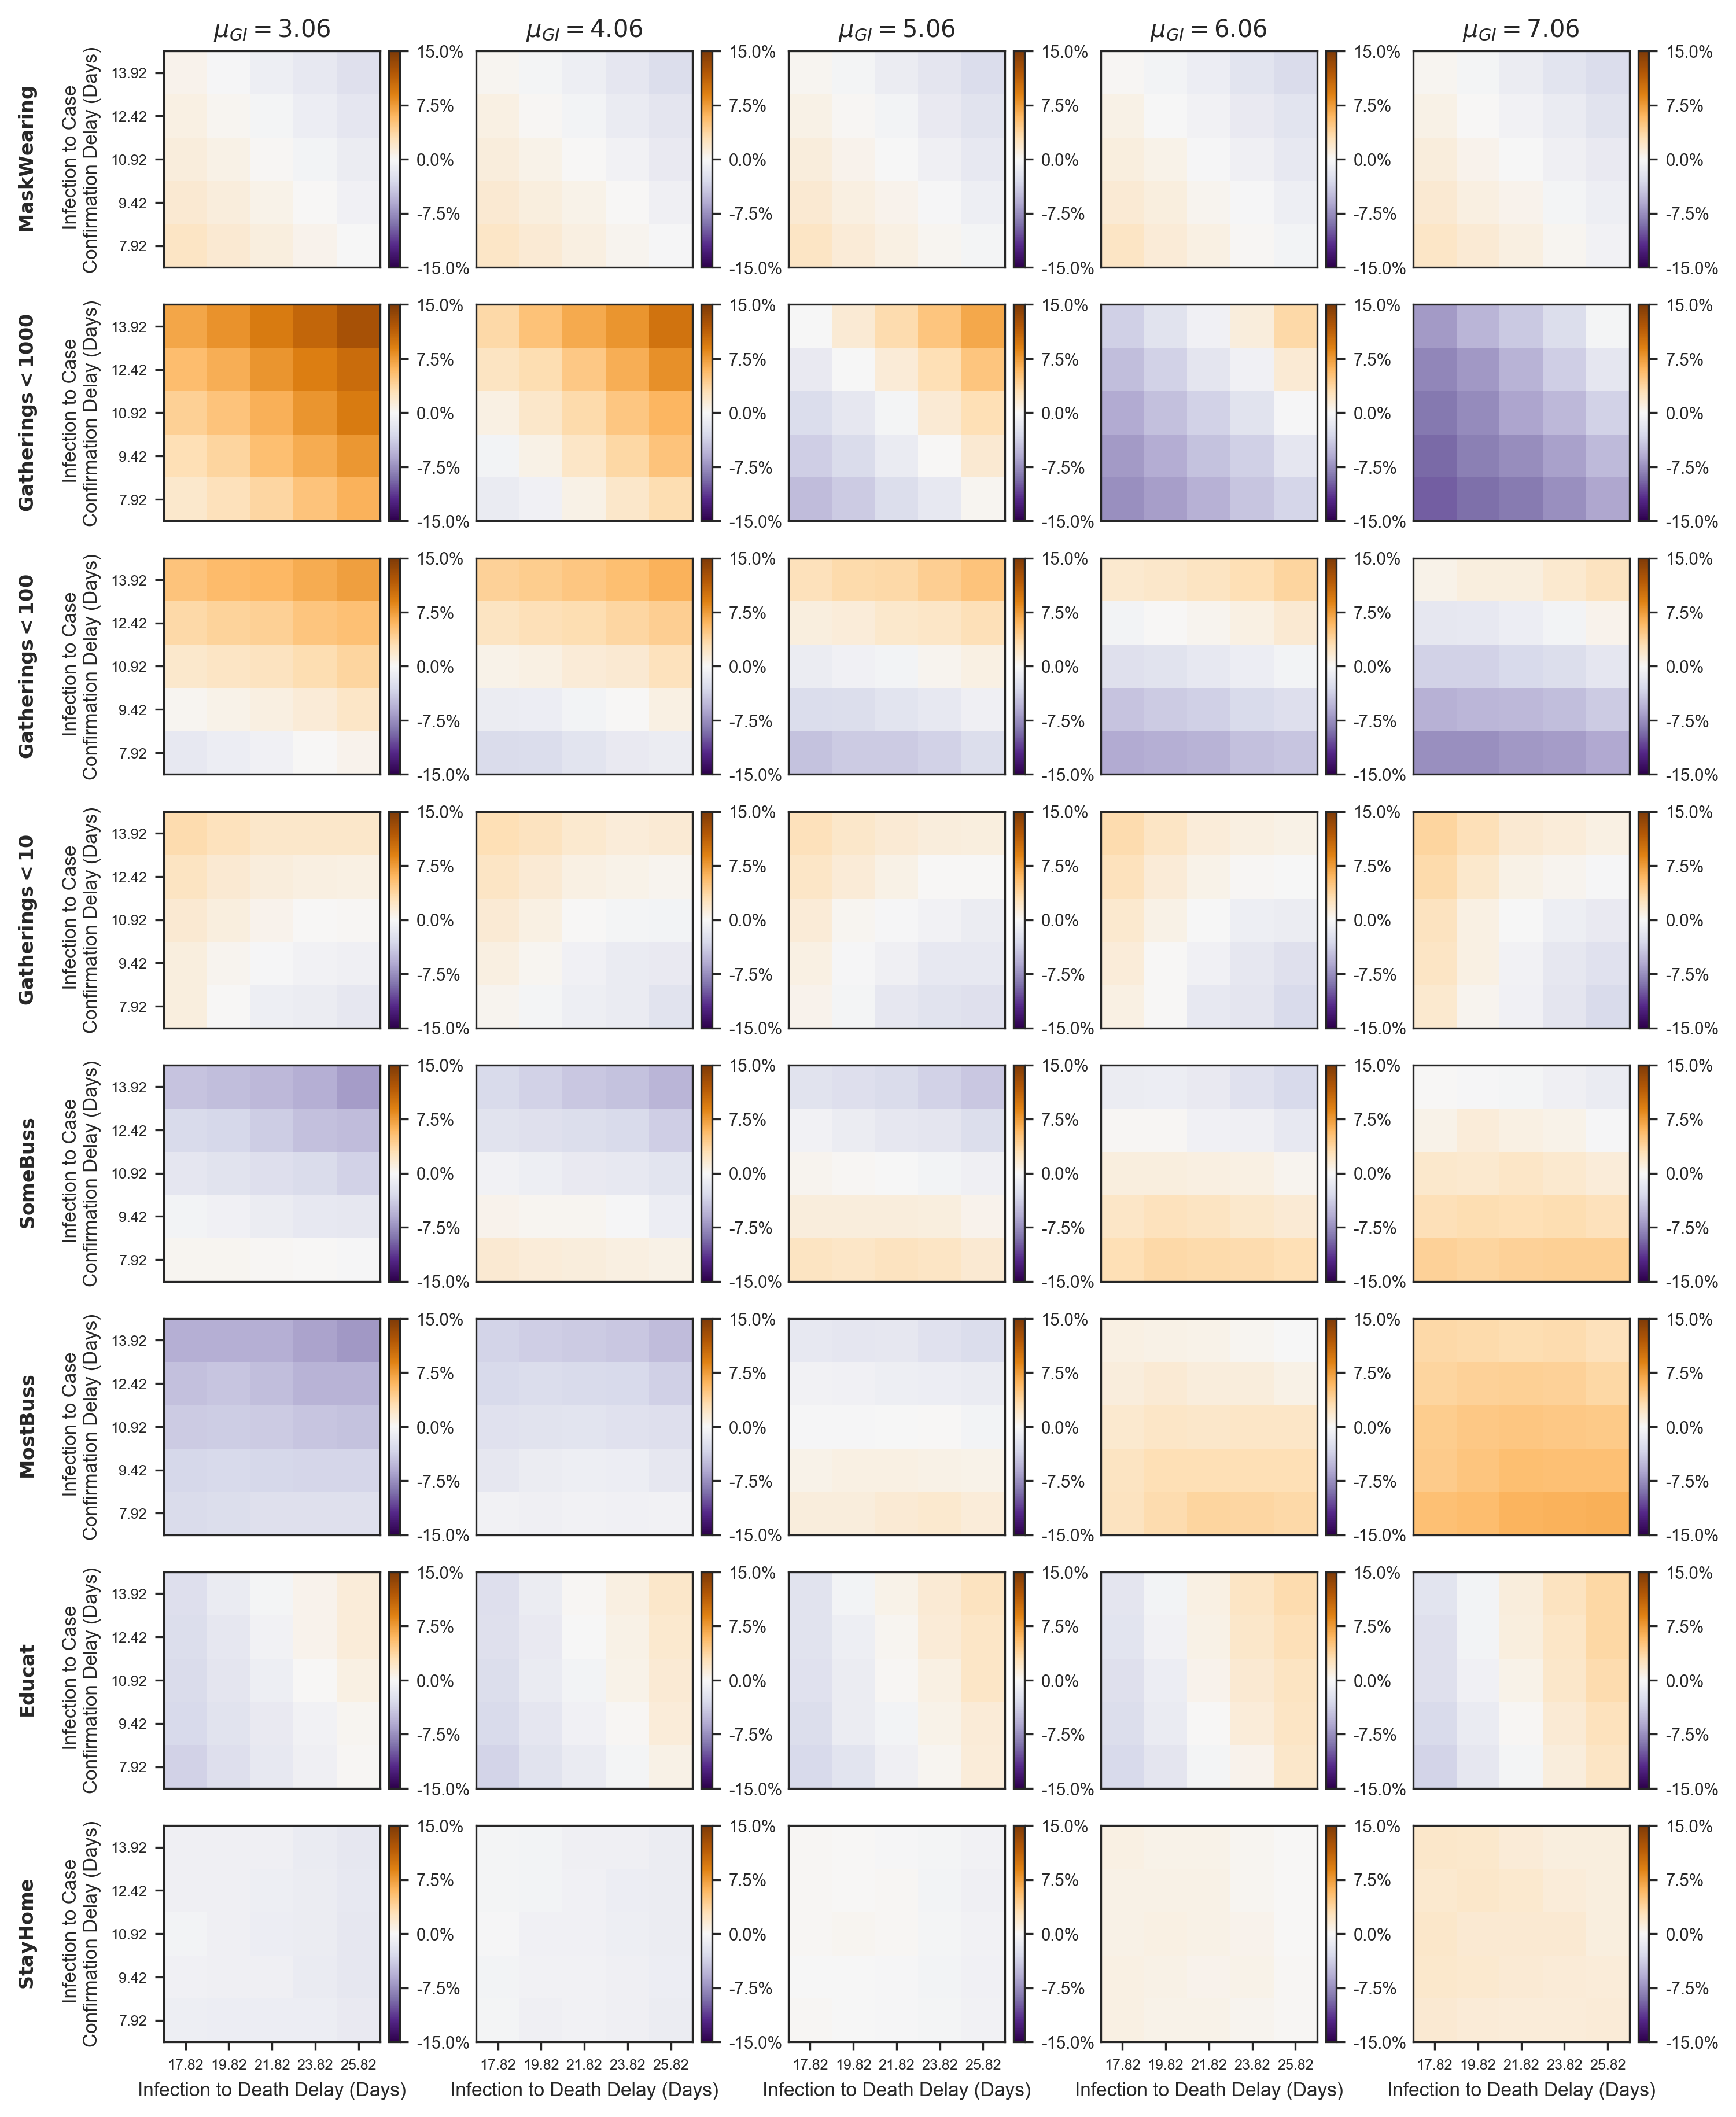

In [29]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import PercentFormatter

current_cmap = mpl.cm.get_cmap('PuOr_r')
current_cmap.set_bad(color='k')

plt.figure(figsize=(10, 14), dpi=300)
for cm in range(8):
    for gi_ind, gi in enumerate(unique_gis.tolist()):
        plt.subplot(8, 5, 5*cm + gi_ind + 1)
        grid = gi_to_grid(cm, global_traces, unique_cds, unique_dds, gi, default_median)
        im = plt.imshow(grid, cmap=current_cmap, origin='lower', vmin=-15, vmax=15)
        plt.xticks([])
        plt.yticks([])
        
        if cm == 0:
            plt.title(f'$\\mu_{{GI}}={gi:.2f}$', fontsize=10)
        
        if gi_ind == 0:
            plt.ylabel(f'$\\bf{short_names[cm]}$\n\n Infection to Case\nConfirmation Delay (Days)', fontsize=8)
            plt.yticks(np.arange(5), unique_cds, fontsize=6)
            
        if cm == 7:
            plt.xlabel(f'Infection to Death Delay (Days)', fontsize=8)
            plt.xticks(np.arange(5), unique_dds, fontsize=6)
            
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbr = plt.colorbar(im, cax=cax, format=PercentFormatter())
        ax = plt.gca()
        ax.tick_params(axis="both", which="major", labelsize=7)
        cbr.set_ticks([-15, -7.5, 0, 7.5, 15])
#         cbr.set_label('$\\Delta$(Median) Effectivenss\n Estimate', fontsize=8)
        
plt.tight_layout(w_pad=-0.5, h_pad=-12)
plt.savefig(f"figs/validation/FigureGlobalSAAll.pdf", bbox_inches='tight')

In [30]:
f;

NameError: name 'f' is not defined

### Compressed Version

In [31]:
def combine_traces(filter_lambda, global_traces):
    filtered_traces = list(filter(filter_lambda, global_traces))
    
    nF = 9
    samples = np.zeros((0, nF))
    
    for _, _, _, _, t in filtered_traces:
        samples = np.append(samples, t, axis=0)
    
    return samples

In [32]:
cd_traces = []
for unique_cd in unique_cds:
    cd_traces.append((combine_traces(lambda t: t[2] == unique_cd, global_traces), f'Mean {unique_cd} days'))
    
gi_traces = []
for unique_gi in unique_gis:
    gi_traces.append((combine_traces(lambda t: t[1] == unique_gi, global_traces), f'Mean {unique_gi} days'))
    
dd_traces = []
for unique_dd in unique_dds:
    dd_traces.append((combine_traces(lambda t: t[3] == unique_dd, global_traces), f'Mean {unique_dd} days'))

[0.62744595 1.82912402 2.39649663 0.93200282 1.66318043 1.04138164
 0.42083021 0.03020239]
1.1175830120082564
Produced stored using [[]]
[0.83502284 1.85702407 0.61889379 0.85820182 0.42966443 0.14769096
 1.44221027 0.24611133]
0.8043524395028772
Produced stored using [[]]
[0.08127446 4.23056761 1.8127681  0.27734422 1.39885146 2.78549617
 0.46647226 0.84481437]
1.4871985810189123
Produced stored using [[]]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


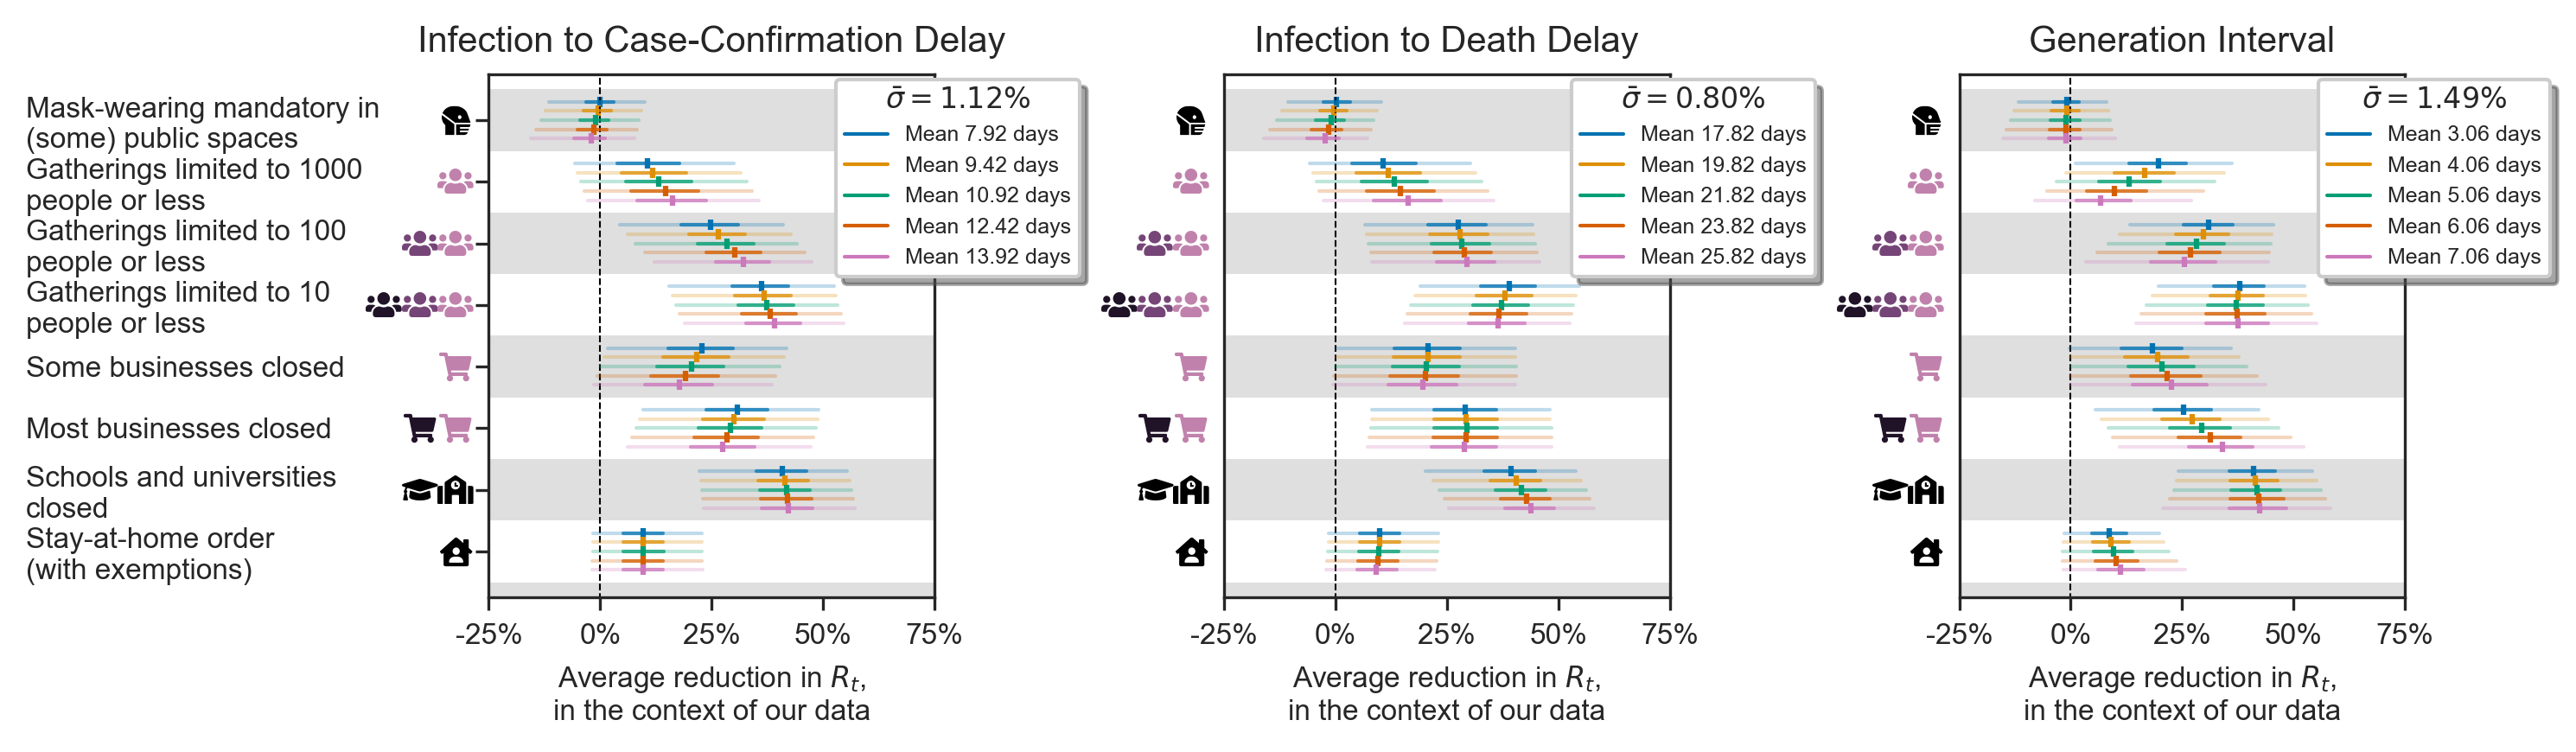

In [33]:
fig = plt.figure(figsize=(10.25, 3), dpi=300)
plt.subplot(131)
setup_large_plot()
score = produce_score_sd(default_res, cd_traces, derived_features_comb)
y_off = -np.linspace(-0.3, 0.3, len(cd_traces))
width = 1
for i, (trace, label) in enumerate(cd_traces):
    add_trace_to_plot(trace, y_off[i], colors[i], label, 1, width)

plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.35, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("Infection to Case-Confirmation Delay", fontsize="10")

plt.subplot(132)
score = produce_score_sd(default_res, dd_traces, derived_features_comb)
setup_large_plot(False, True, True)
y_off = -np.linspace(-0.3, 0.3, len(dd_traces))
width = 1
for i, (trace, label) in enumerate(dd_traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)

plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.35, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("Infection to Death Delay", fontsize="10")

plt.subplot(133)
score = produce_score_sd(default_res, gi_traces, derived_features_comb)
setup_large_plot(False, True, True)
y_off = -np.linspace(-0.3, 0.3, len(gi_traces))
width = 1
for i, (trace, label) in enumerate(gi_traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)

plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.35, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("Generation Interval", fontsize="10")

plt.tight_layout(w_pad=-2)
plt.savefig(f"figs/validation/FigureEpiparamCompressed.pdf", bbox_inches='tight')

In [34]:
f;

NameError: name 'f' is not defined

# rebutall thing

In [ ]:
filtered_traces = list(filter(lambda t: t[1] == 5.06 , global_traces))

In [ ]:
a_traces = [(t, f'CD: {cd}d\nDD: {dd}d') for _, _, cd, dd, t in filtered_traces[:8]]

b_traces = [(t, f'CD: {cd}d\nDD: {dd}d') for _, _, cd, dd, t in filtered_traces[8:16]]

c_traces = [(t, f'CD: {cd}d\nDD: {dd}d') for _, _, cd, dd, t in filtered_traces[16:]]

In [ ]:
fig = plt.figure(figsize=(10.25, 3), dpi=300)
plt.subplot(131)

plt.plot([17.5, 17.5], [2, -10], 'k--', linewidth=0.75)
plt.plot([35, 35], [2, -10], 'k--', linewidth=0.75)
setup_large_plot()
y_off = -np.linspace(-0.3, 0.3, len(a_traces))
width = 1
for i, (trace, label) in enumerate(a_traces):
    add_trace_to_plot(trace, y_off[i], colors[i], label, 1, width)


    
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.35, 1.01), fontsize=6)

plt.subplot(132)
plt.plot([17.5, 17.5], [2, -10], 'k--', linewidth=0.75)
plt.plot([35, 35], [2, -10], 'k--', linewidth=0.75)
setup_large_plot(False, True, True)
y_off = -np.linspace(-0.3, 0.3, len(b_traces))
width = 1
for i, (trace, label) in enumerate(b_traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)

plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.35, 1.01), fontsize=6)

plt.subplot(133)
plt.plot([17.5, 17.5], [2, -10], 'k--', linewidth=0.75)
plt.plot([35, 35], [2, -10], 'k--', linewidth=0.75)
setup_large_plot(False, True, True)
y_off = -np.linspace(-0.3, 0.3, len(c_traces))
width = 1
for i, (trace, label) in enumerate(c_traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)

plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.35, 1.01), fontsize=6)

plt.tight_layout(w_pad=-2)
plt.savefig(f"figs/validation/FigureEpiparamCompressed.pdf", bbox_inches='tight')

In [ ]:
f;

# ascertainment rates

Text(0.5, 1.0, 'Time Varying Case Undercounting Correction')

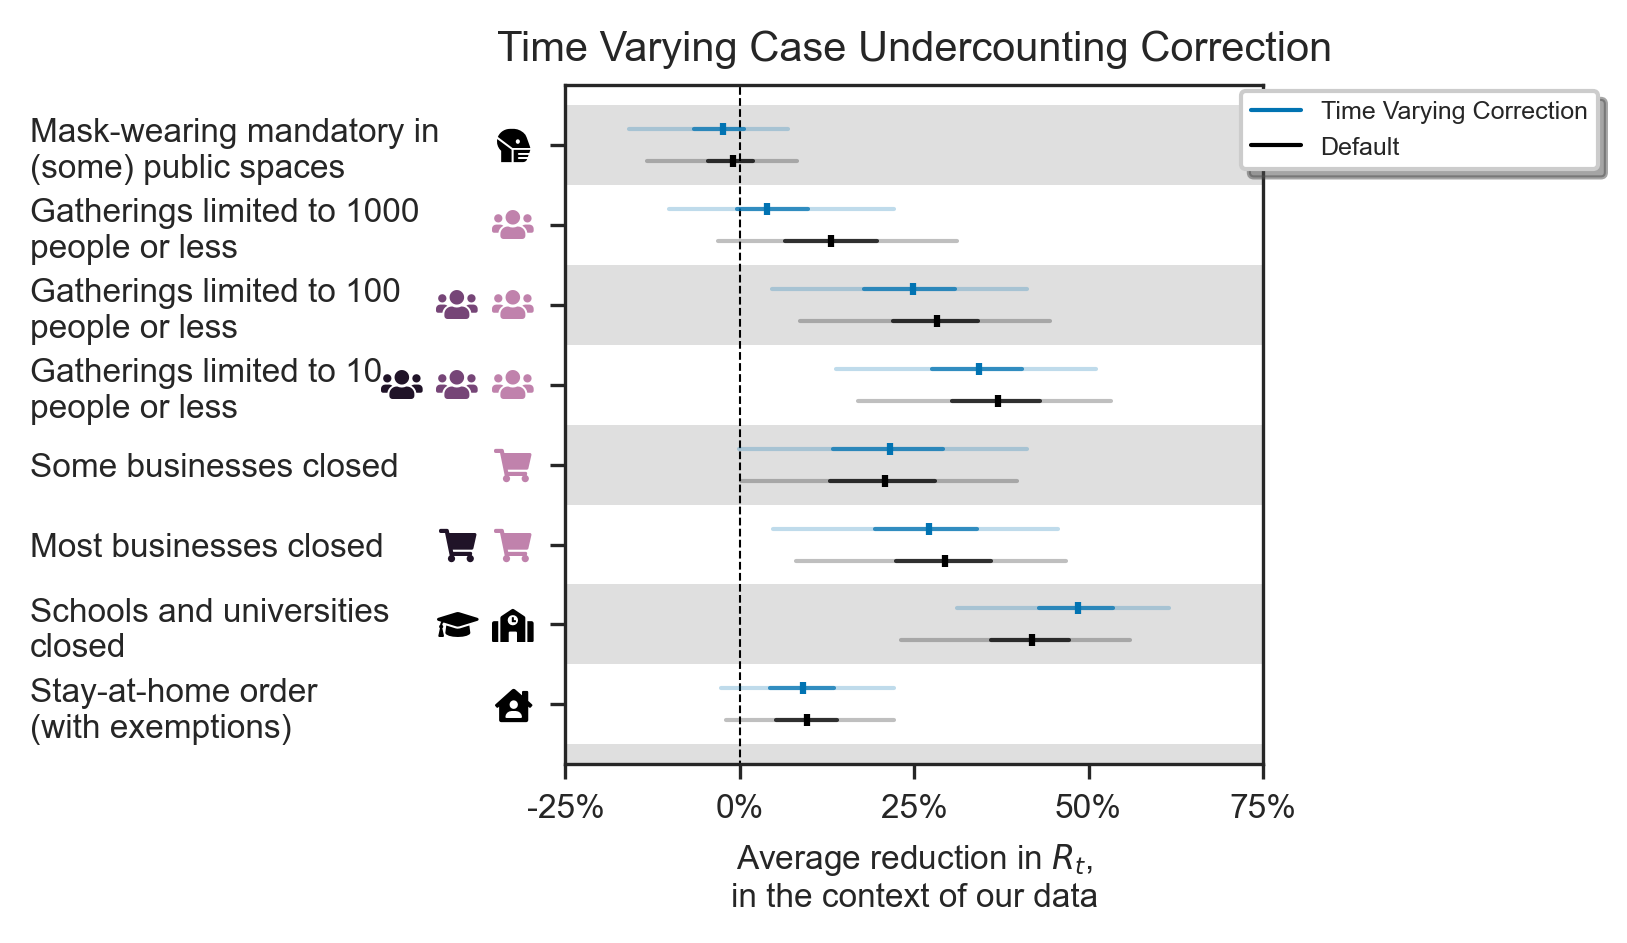

In [18]:
fig = plt.figure(figsize=(3, 3), dpi=300)
setup_large_plot()

traces = load_tagged_traces(results_base_dir, "scalings")

derived_features = derived_features_comb

width = 1

add_trace_to_plot(np.exp(-traces[0][0]), 0.2, colors[0], "Time Varying Correction", 1, width)
add_trace_to_plot(default_res, -0.2, 'k', "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6)
plt.title("Time Varying Case Undercounting Correction", fontsize="10")

In [ ]:
fig = plt.figure(figsize=(3.1, 2.75), dpi=300)
setup_large_plot()

derived_features = derived_features_comb
traces = load_tagged_traces(results_base_dir, "scalings")
traces = [(np.exp(-t), l) for t, l in traces]
score = produce_score_sd(default_res, traces, derived_features_comb)

y_off = -np.linspace(-0.2, 0.2, len(traces)+1)
width = 1
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace, y_off[i], colors[i], label, 1, width)

add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("Case Undercounting", fontsize="10")
plt.savefig(f"figs/validation/FigureUndercounting.pdf", bbox_inches='tight')

In [ ]:
f

# identifiabily results

In [ ]:
synth_cmred = np.exp(-np.loadtxt('synth.txt'))
med_cmred = np.exp(-np.loadtxt('medians.txt'))

In [ ]:
synth_cmred.shape

In [ ]:
fig = plt.figure(figsize=(4.5, 3), dpi=300)

setup_large_plot()
width = 1

derived_features = derived_features_comb

plt.scatter(100*(1-np.exp(-np.array([0.  , 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]))), -np.arange(8)+0.15,
           color=colors[3], s=6, marker='v')
plt.scatter(100*(1-np.exp(-np.array([0.  , 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]))), -np.arange(8)-0.15,
           color=colors[3], s=6, marker='^')

add_trace_to_plot(synth_cmred, 0.0, colors[0], '', 1, width)
# plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\bar{{\\sigma}}={score:.2f}\\%$', title_fontsize=8)
plt.title("Synthetic $\\alpha_i$", fontsize=10)


plt.tight_layout()
plt.savefig(f"figs/validation/FigureIdent.pdf", bbox_inches='tight')

In [ ]:
np.linspace(0, 0.4, 8)

In [ ]:
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

In [ ]:
[0, 0.05, 0.05, 0.05, 0.2, 0.05, 0.15, 0.15, 0.35]